<a href="https://colab.research.google.com/github/hamzarabi3/DataSciencePortfolio/blob/master/veao_statistical_tsa_univariate_forecast_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Exploratory data analysis 



In [0]:
import pandas as pd 
import numpy as np 
import pickle 
from matplotlib.pyplot import rcParams
from sklearn.metrics import mean_squared_error

rcParams['figure.figsize']=20,10 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

In [0]:
df=pd.read_csv('../input/01_OND_df.csv',index_col=0)
df=df.set_index('TimeStamp')
df.index=pd.to_datetime(df.index)
energy=['P_totale(kw)','Q_totale(kvar)', 'S_totale(kva)', 'Energie_active_cons(kwh)','P_moyenne(kw)']
currents=['I1', 'I2', 'I3', 'C_T']
voltages=['U12', 'U23', 'U31', 'U123']

## 1.1 Descriptive statistics(min, max, std, mean, Q1, Q2, Q3)

In [0]:
df.describe()

,I1,I2,I3,C_T,U12,U23,U31,U123,P_totale(kw),P_moyenne(kw),Q_totale(kvar),S_totale(kva),Energie_active_cons(kwh)
count,17711.000000,17711.000000,17711.000000,17711.000000,17711.000000,17711.000000,17711.000000,17711.000000,17711.000000,17711.000000,17711.000000,17711.000000,17710.000000
mean,8.749873,7.505279,7.991531,8.087403,407.298120,404.369206,403.986336,405.219638,3.991418,7.682965,-3.889334,5.621930,1.008760
std,4.401247,3.241313,3.932568,3.677688,2.958054,2.827277,3.026149,2.915482,2.372993,348.167381,1.250028,2.563022,1.506998
min,4.000000,3.000000,3.000000,4.000000,387.000000,383.000000,383.000000,385.000000,1.000000,1.000000,-8.000000,2.000000,0.220000
25%,6.000000,5.000000,5.000000,6.000000,405.000000,403.000000,402.000000,403.000000,2.000000,2.000000,-5.000000,4.000000,0.601000
50%,7.000000,6.000000,6.000000,6.000000,408.000000,405.000000,404.000000,405.000000,3.000000,3.000000,-3.000000,4.000000,0.725000
75%,11.000000,9.000000,10.000000,10.000000,409.000000,406.000000,406.000000,407.000000,5.000000,5.000000,-3.000000,7.000000,1.332000
max,36.000000,25.000000,34.000000,24.000000,418.000000,415.000000,414.000000,415.000000,15.000000,32768.000000,-2.000000,17.000000,186.248000


## 1.2 Overall trend

In [0]:
zoom=df.loc["2019-09-25":"2019-10-01"] 

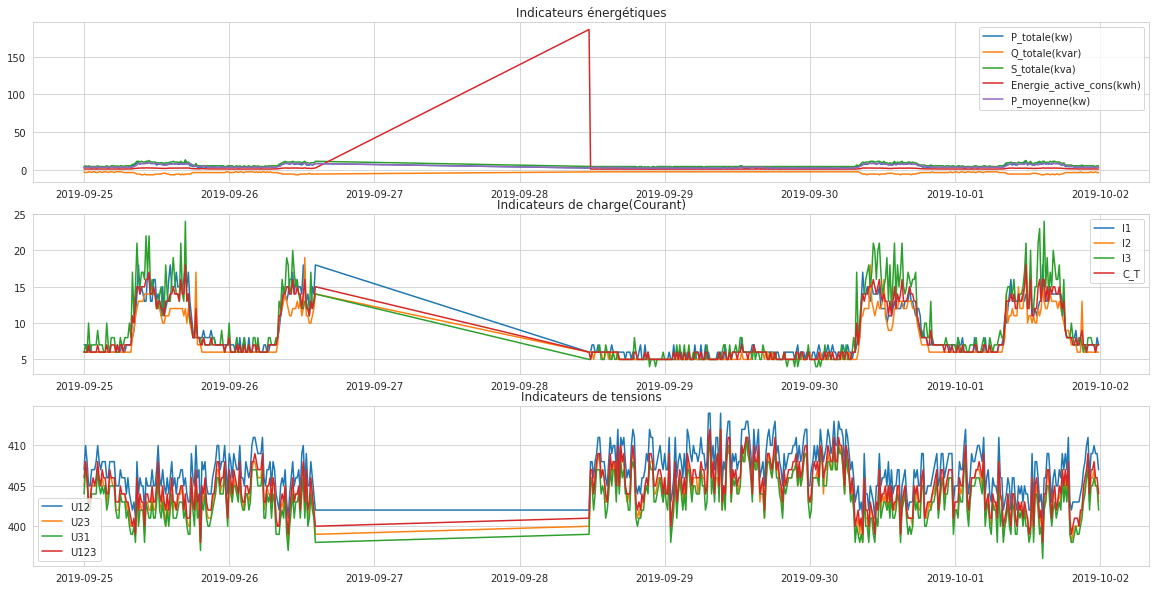

In [0]:
ax=plt.subplot(3,1,1)
plt.plot(zoom[energy])
plt.legend(labels=energy)
plt.title('Indicateurs énergétiques')
ax=plt.subplot(3,1,2,sharex=ax)
plt.plot(zoom[currents])
plt.legend(labels=currents)
plt.title('Indicateurs de charge(Courant)')
plt.subplot(3,1,3,sharex=ax)
plt.plot(zoom[voltages]);
plt.legend(labels=voltages)
plt.title('Indicateurs de tensions');

>* **We notice that towards the end of month 9, the values became distorted, for the moment I will eliminate all the points from this period so as not to have time gaps.** <br>
>* **We can also notice that `P_moyennes` is always null.**

In [0]:
df.drop(['P_moyenne(kw)'],inplace=True,axis=1)
df=df.loc[:'2019-09-26']# les valeurs distordues
df=df.iloc[1:]# la premiers valeurs de Energies_cons est NA

In [0]:
def add_freq(idx, freq=None):
    """Add a frequency attribute to idx, through inference or directly.

    Returns a copy.  If `freq` is None, it is inferred.
    """

    idx = idx.copy()
    if freq is None:
        if idx.freq is None:
            freq = pd.infer_freq(idx)
        else:
            return idx
    idx.freq = pd.tseries.frequencies.to_offset(freq)
    if idx.freq is None:
        raise AttributeError('no discernible frequency found to `idx`.  Specify'
                             ' a frequency string with `freq`.')
    return idx

***A cause d l'existence des sauts dans les mesures la frequences d'echatillonage originale de 15min ne semble pas valide, je vais la rendre 30min en prennant la moyenne sur tous les deux points***

In [0]:
resampled=df.resample(rule='30T').mean() #changer la periode d'echantillonage de 15min a 30min
resampled.index=add_freq(resampled.index)

In [0]:
vis_window=resampled.loc['2019-07-01':'2019-07-3'] # 3 jours

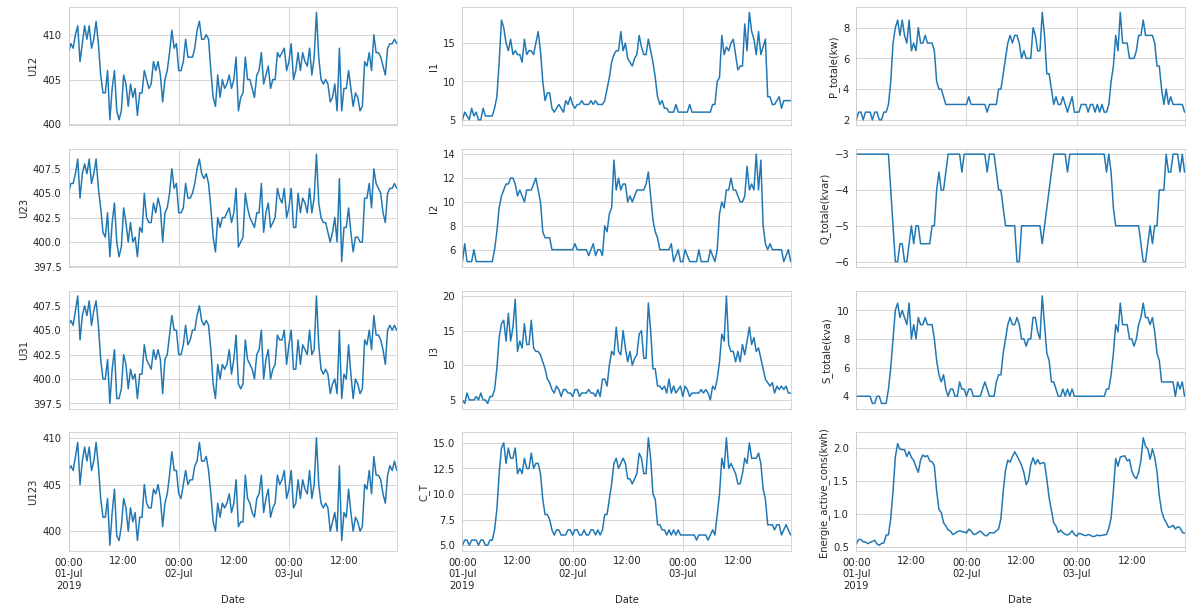

In [0]:
ax=plt.subplot(4,3,1)
vis_window[voltages[0]].plot();
plt.ylabel(voltages[0])
ax=plt.subplot(4,3,2,sharex=ax)
vis_window[currents[0]].plot();
plt.ylabel(currents[0])
plt.subplot(4,3,3,sharex=ax)
vis_window[energy[0]].plot();
plt.ylabel(energy[0])

ax=plt.subplot(4,3,4)
vis_window[voltages[1]].plot();
plt.ylabel('\n'+voltages[1])
ax=plt.subplot(4,3,5,sharex=ax)
vis_window[currents[1]].plot();
plt.ylabel('\n'+currents[1])
plt.subplot(4,3,6,sharex=ax)
vis_window[energy[1]].plot();
plt.ylabel('\n'+energy[1])

ax=plt.subplot(4,3,7)
vis_window[voltages[2]].plot();
plt.ylabel('\n'+voltages[2])
ax=plt.subplot(4,3,8,sharex=ax)
vis_window[currents[2]].plot();
plt.ylabel('\n'+currents[2])
plt.subplot(4,3,9,sharex=ax)
vis_window[energy[2]].plot();
plt.ylabel('\n'+energy[2])

ax=plt.subplot(4,3,10)
vis_window[voltages[3]].plot();
plt.ylabel('\n'+voltages[3])
plt.xlabel('Date');
ax=plt.subplot(4,3,11,sharex=ax)
vis_window[currents[3]].plot();
plt.ylabel('\n'+currents[3])
plt.xlabel('Date');
plt.subplot(4,3,12,sharex=ax)
vis_window[energy[3]].plot();
plt.ylabel('\n'+energy[3]);
plt.xlabel('Date');

# 1.3 Error, Trend, Seasonality Decomposition (ETS) 

An ETS decomposition assumes that the time series is a sum or product of three elements:
> * **Trend:** The general trend of the series. <br>
> * **Seasonality:** A component of seasonality which fluctuates with a period specified by the analyst, In our case I work on the assumption of a weekly seasonality.
> * **Error:** the residual of the original series is the two previous components, a small Error component means that we have correctly described the series with these two components. <br>

In our case, we use the ***STL: Seasonal-Trend decomposition using LOESS (Locally Estimated Scatterplot Smoothing)*** method.

In [0]:
from statsmodels.tsa.seasonal import STL
resampled.dropna(inplace=True)
periode=48*7+1 #(48 points par jours)

**Active Energy Consumption**

**a) Neglect outliers**

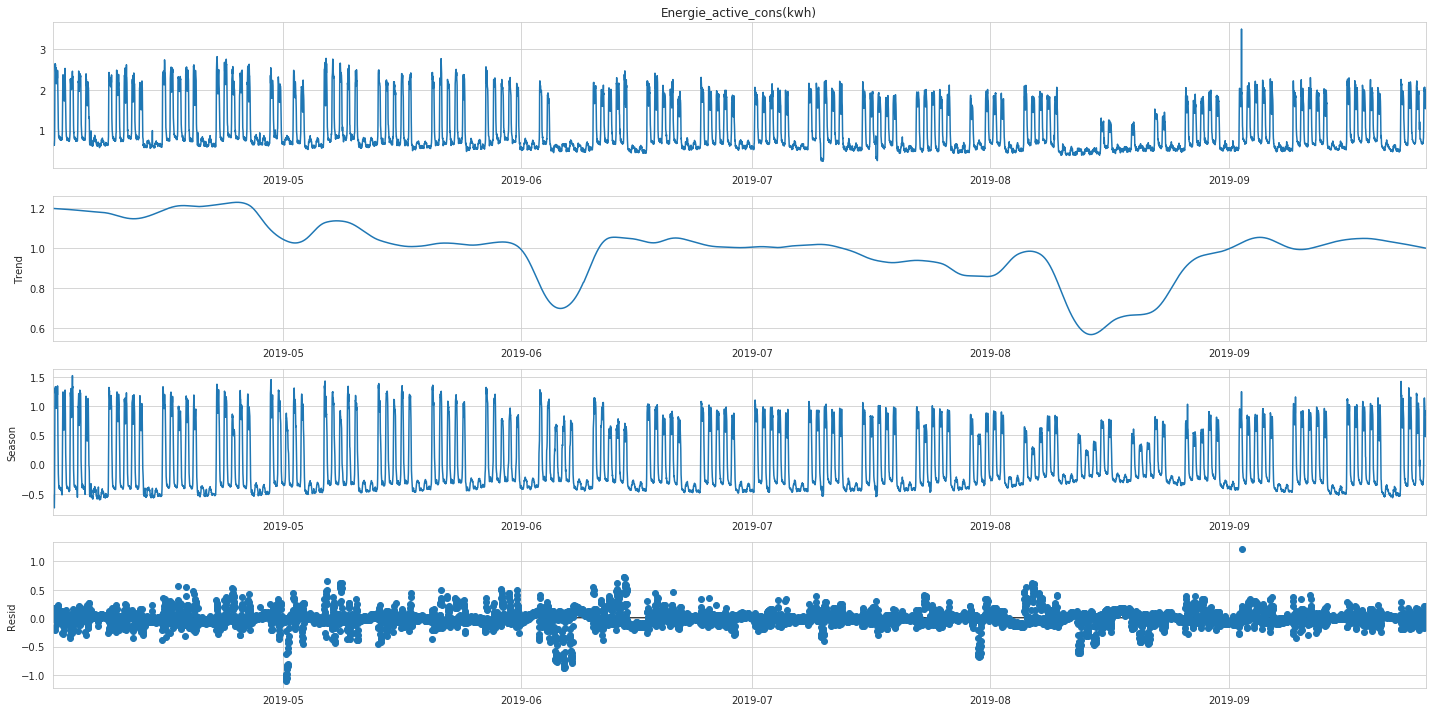

In [0]:
results=STL(resampled[energy[3]],period=periode).fit()# supposons le modele est additive y=s+e+t
results.plot();

**Interpretation:**
>* The one-week seasonal assumption seems realistic, but with a significant error report. This is mainly due to the presence of a number of anomalies (outliers) in the series, which can be the subject of an **Anomaly Detection** exercise, which I will address in a second iteration of this work.
>* We can clearly see the effect of vacations on the `trend` component which indicates that adding some exogenous data like vacation days can improve the prediction model.

# 2. Modeling and predictions (Univariate) 

In [0]:
results=[]

**Train-test split**

In [0]:
test_size=round(len(resampled)*0.2)
test_set=resampled.iloc[-test_size:].copy()
train_set=resampled.iloc[:-test_size].copy()
print(f'testing percentage: {round(len(test_set)/len(resampled)*100)}%')

# 2.1 Exponential Smoothing

<span style="margin-left:15"> **Summary of  Exponential Smoothing**</span> <br>
<br>
<br>
![Taxonomie des modeles ES](https://otexts.com/fpp2/pegelstable.png)

## 2.1.1 Triple ES

In [0]:
from statsmodels.tsa.api import ExponentialSmoothing

fit3=ExponentialSmoothing(train_set[energy[3]],trend='mul',seasonal='mul',seasonal_periods=periode).fit()
fit4=ExponentialSmoothing(train_set[energy[3]],trend='mul',seasonal='add',seasonal_periods=periode).fit()
fit5=ExponentialSmoothing(train_set[energy[3]],trend='add',seasonal='add',seasonal_periods=periode).fit()
fit6=ExponentialSmoothing(train_set[energy[3]],trend='add',seasonal='mul',seasonal_periods=periode).fit()

train_set['TES_cons_**']=fit3.fittedvalues.shift(-1)
train_set['TES_cons_*+']=fit4.fittedvalues.shift(-1)
train_set['TES_cons_++']=fit5.fittedvalues.shift(-1)
train_set['TES_cons_+*']=fit6.fittedvalues.shift(-1)

test_set['TES_fcast_**']=fit3.forecast(len(test_set)).values
test_set['TES_fcast_*+']=fit4.forecast(len(test_set)).values
test_set['TES_fcast_++']=fit5.forecast(len(test_set)).values
test_set['TES_fcast_+*']=fit6.forecast(len(test_set)).values

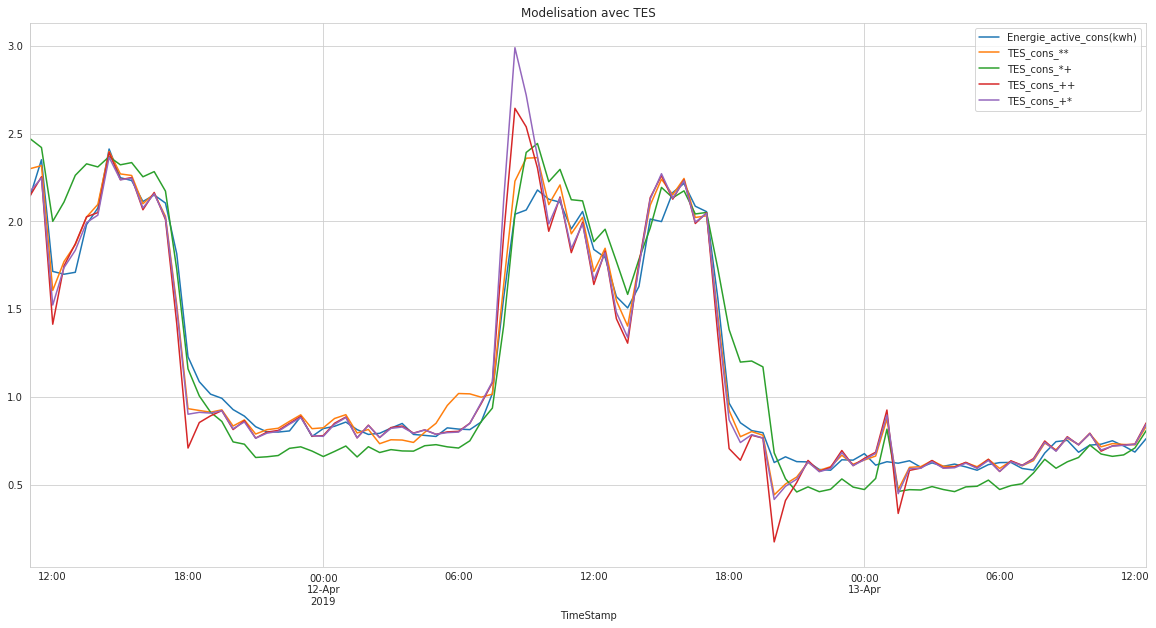

In [0]:
train_set[[energy[3],'TES_cons_**','TES_cons_*+','TES_cons_++','TES_cons_+*']].iloc[500:600].plot();
plt.title('Modelisation avec TES');

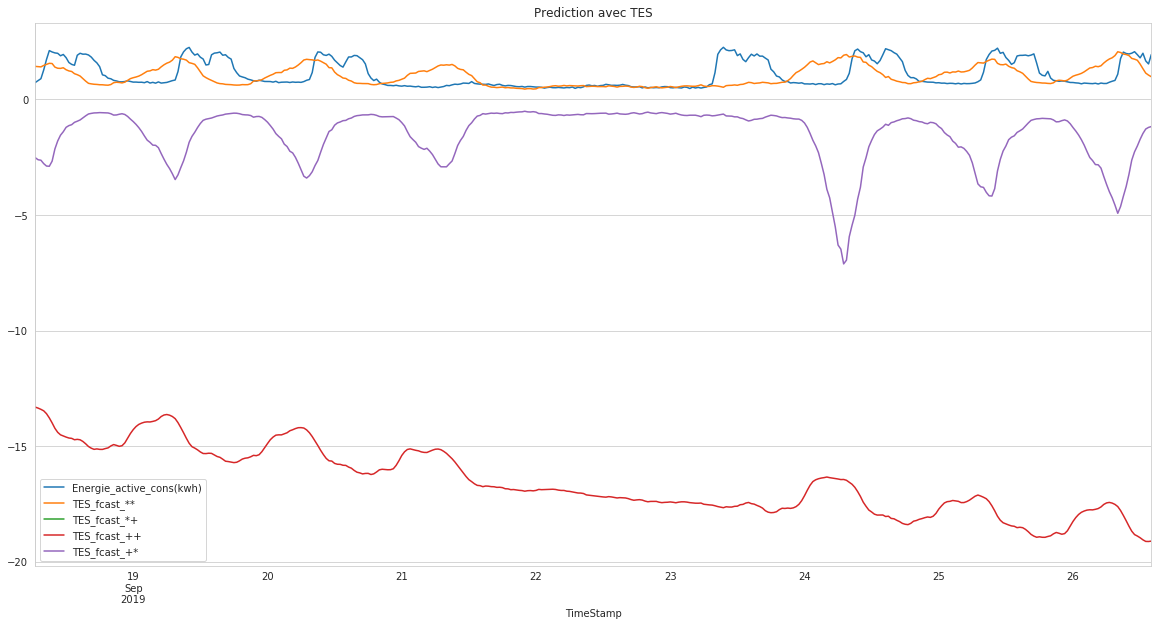

In [0]:
test_set[[energy[3],'TES_fcast_**','TES_fcast_*+','TES_fcast_++','TES_fcast_+*']].iloc[-400:].plot();
plt.title('Prediction avec TES');

In [0]:
results.append(mean_squared_error(test_set[energy[3]],test_set['TES_fcast_**']))

## 2.1.1 Damped TES

In [0]:
fit7=ExponentialSmoothing(train_set[energy[3]],trend='mul',seasonal='mul',seasonal_periods=periode,damped=True).fit()
fit8=ExponentialSmoothing(train_set[energy[3]],trend='mul',seasonal='add',seasonal_periods=periode,damped=True).fit()
fit9=ExponentialSmoothing(train_set[energy[3]],trend='add',seasonal='add',seasonal_periods=periode,damped=True).fit()
fit10=ExponentialSmoothing(train_set[energy[3]],trend='add',seasonal='mul',seasonal_periods=periode,damped=True).fit()

train_set['TES_cons_**d']=fit7.fittedvalues.shift(-1)
train_set['TES_cons_*+d']=fit8.fittedvalues.shift(-1)
train_set['TES_cons_++d']=fit9.fittedvalues.shift(-1)
train_set['TES_cons_+*d']=fit10.fittedvalues.shift(-1)

test_set['TES_fcast_**d']=fit7.forecast(len(test_set)).values
test_set['TES_fcast_*+d']=fit8.forecast(len(test_set)).values
test_set['TES_fcast_++d']=fit9.forecast(len(test_set)).values
test_set['TES_fcast_+*d']=fit10.forecast(len(test_set)).values

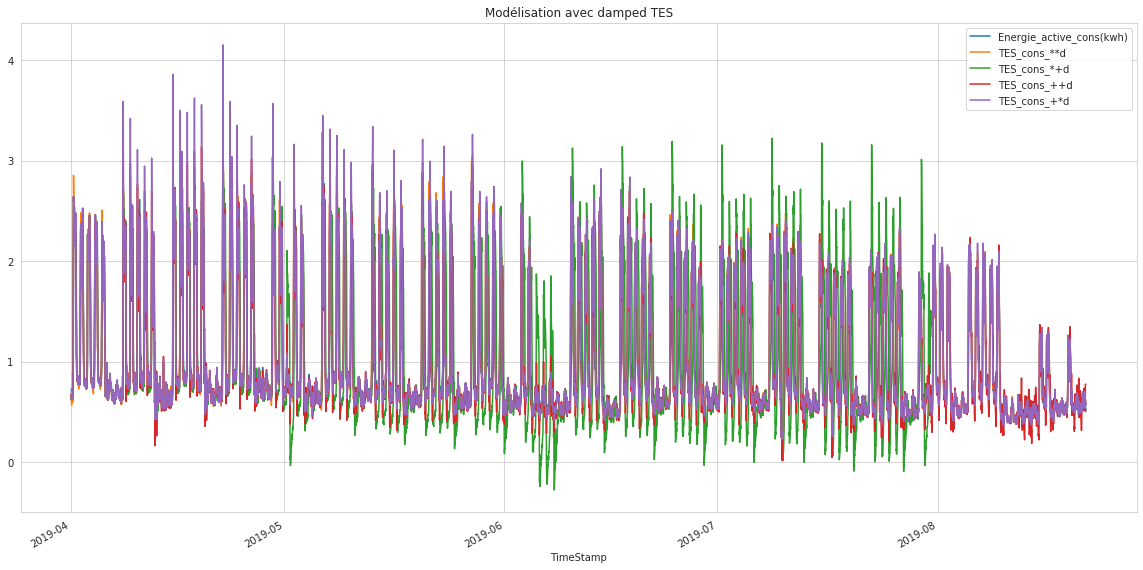

In [0]:
train_set[[energy[3],'TES_cons_**d','TES_cons_*+d','TES_cons_++d','TES_cons_+*d']].plot();
plt.title('Modélisation avec damped TES');

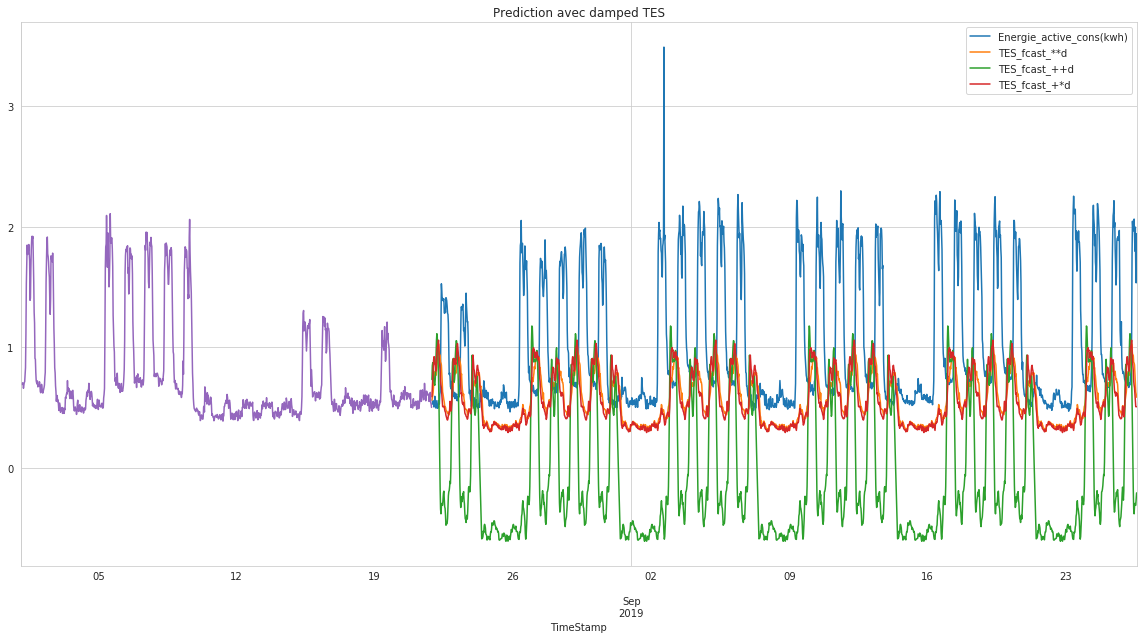

In [0]:
test_set[[energy[3],'TES_fcast_**d','TES_fcast_++d','TES_fcast_+*d']].plot()
train_set[energy[3]].iloc[-1000:].plot()
plt.title('Prediction avec damped TES');

In [0]:
results.append(mean_squared_error(test_set[energy[3]],test_set['TES_fcast_**d']))

# 2.2 ARIMA (AutoRegressive Integrated Moving Average)

## 2.1 Stationnarity
**Augmented Dickey-Fuller test**

In [0]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [0]:
adf_test(train_set[energy[3]])

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.256565e+00
p-value                 5.218001e-13
# lags used             3.400000e+01
# observations          6.820000e+03
critical value (1%)    -3.431309e+00
critical value (5%)    -2.861964e+00
critical value (10%)   -2.566996e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


## Forecasting with ARIMA

In [0]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import optuna
data=resampled.resample(rule='60T').mean().dropna()
train_set=data.iloc[:-286]
test_set=data.iloc[-286:]

In [0]:
train_sample=train_set.iloc[-1000:]
horizon=286
test_sample=test_set#.iloc[:horizon]

In [0]:
model = SARIMAX(train_set[energy[3]],order=(2,1,1),seasonal_order=(1,0,1,24))
results = model.fit()
fcast = results.predict(len(train_set),len(train_set)+horizon-1)
train_set['SARIMA']=results.predict(0,len(train_set)-1).values
test_set['SARIMA']=fcast.values
print(mean_squared_error(test_set['SARIMA'],test_set[energy[3]]))

0.14626525327194262


In [0]:
model = SARIMAX(train_set[energy[3]],order=(2,1,1),seasonal_order=(2,0,3,24))
results = model.fit()
fcast = results.predict(len(train_set),len(train_set)+horizon-1)
train_set['SARIMA']=results.predict(0,len(train_set)-1).values
test_set['SARIMA']=fcast.values
print(mean_squared_error(test_set['SARIMA'],test_set[energy[3]]))

0.17044980819547065


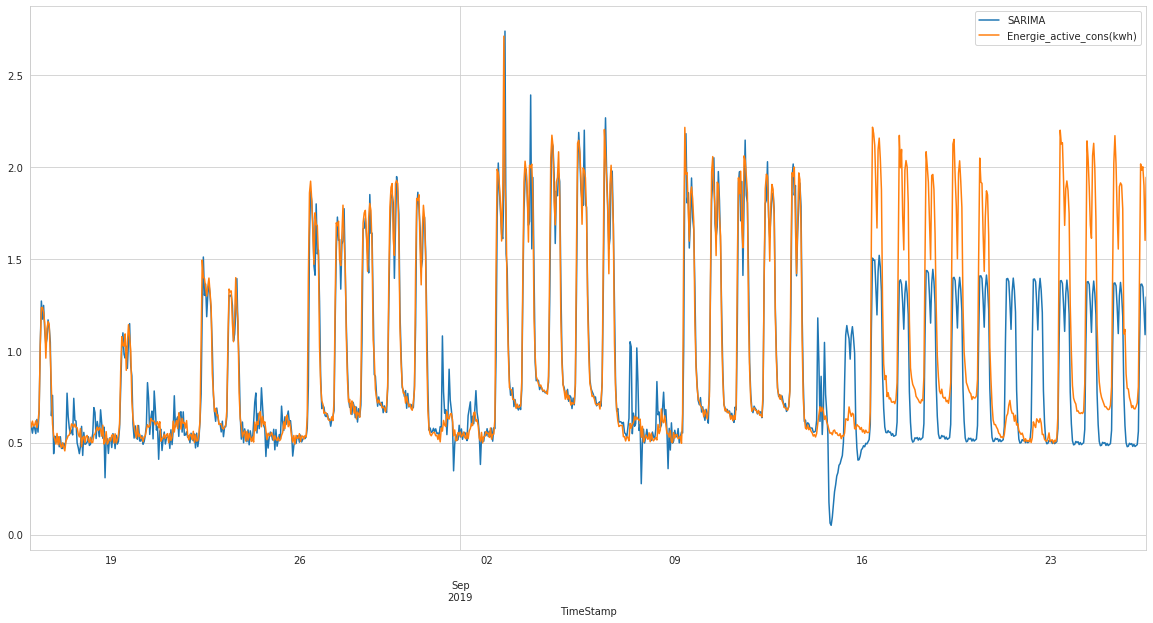

In [0]:
plotable=pd.concat([train_set[['SARIMA',energy[3]]],test_set[['SARIMA',energy[3]]]],axis=0)
plotable.iloc[-1000:].plot();